In [ ]:
import LLMSR
import openai
import base64
import io
import copy

import numpy as np
import matplotlib.pyplot as plt
import torch.nn

from kan import *

In [2]:
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)
LLMSR.check_key_limit(client)

94.9871512

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.89e-01 | test_loss: 1.95e-01 | reg: 9.17e+00 | : 100%|█| 500/500 [00:35<00:00, 14.02


saving model version 0.1


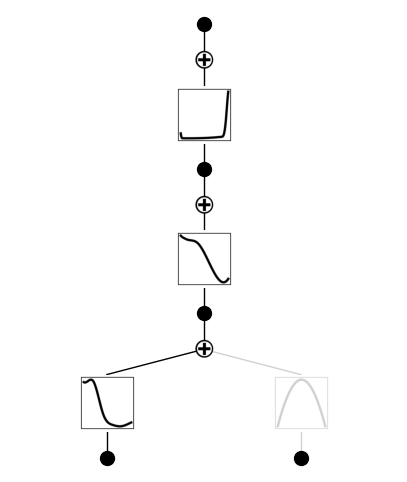

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# initialize KAN with G=3
model = KAN(width=[2,1,1,1], grid=5, k=3, seed=0, device=device, symbolic_enabled=False)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, train_num=10000, test_num=1000, device=device)
res = model.fit(dataset, opt="LBFGS", steps=500);
model.plot()

# fit KANs splines

In [4]:
def generate_base64_image(fig, ax, x, y):
    ax.clear()  # Clear previous plot
    ax.plot(x, y, label='data')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    ax.legend()

    # Save to buffer
    buffer = io.BytesIO()
    fig.savefig(buffer, format='png')
    buffer.seek(0)  # Reset buffer position
    base64_image = base64.b64encode(buffer.getvalue()).decode("utf-8") # encode img into buffer
    buffer.close()  # Close buffer
    return base64_image

def generate_nested_functions(layer_connections):
    """
    Generates a nested function expression for a symbolic computational graph.

    Parameters:
        layer_connections (dict): A dictionary where keys are layer indices (1 to L),
                                  and values are lists of nodes in that layer, 
                                  each containing a list of indices from the previous layer.

    Returns:
        str: Nested function string.
    """
    L = max(layer_connections.keys())
    def construct_layer(l, node):
        """Recursively constructs the function for a given node at layer l."""
        if l == 0:
            # Base case: Input layer directly maps to x_i
            return f"f_{{0,{node}}}(x_{node})"
        else:
            # Construct sum of incoming connections
            inputs = " + ".join([f"f_{{{l},{node}}}({construct_layer(l-1, prev)})" 
                                 for prev in layer_connections[l].get(node, [])])
            return f"({inputs})" if inputs else f"f_{{{l},{node}}}()"  # Handle empty case

    # Construct output as a list
    return [construct_layer(L, node) for node in layer_connections[L]]

def to_symbolic(model, client, population=10, generations=3, temperature=0.1, gpt_model="openai/gpt-4o-mini", exit_condition=1e-3):
    res, res_fcts = 'Sin', {}
    layer_connections = {0: {i: [] for i in range(model.width_in[0])}}
    for l in range(len(model.width_in) - 1):
        layer_connections[l] = {i: list(range(model.width_out[l-1])) if l > 0 else []  for i in range(model.width_in[l])}
    symb_formula = generate_nested_functions(layer_connections)
    
    for l in range(len(model.width_in) - 1):
        for i in range(model.width_in[l]):
            for j in range(model.width_out[l + 1]):
                if (model.symbolic_fun[l].mask[j, i] > 0. and model.act_fun[l].mask[i][j] == 0.):
                    print(f'skipping ({l},{i},{j}) since already symbolic')
                    symb_formula = [s.replace(f'f_{{{l},{i},{j}}}', 'TODO') for s in symb_formula]
                elif (model.symbolic_fun[l].mask[j, i] == 0. and model.act_fun[l].mask[i][j] == 0.):
                    model.fix_symbolic(l, i, j, '0', verbose=verbose > 1, log_history=False)
                    print(f'fixing ({l},{i},{j}) with 0')
                    symb_formula = [s.replace(f'f_{{{l},{i},{j}}}', '0') for s in symb_formula]
                    res_fcts[(l, i, j)] = None
                else:
                    x_min, x_max, y_min, y_max = model.get_range(l, i, j, verbose=False)
                    x, y = model.acts[l][:, i].cpu().detach().numpy(), model.spline_postacts[l][:, j, i].cpu().detach().numpy()
                    ordered_in = np.argsort(x)
                    x, y = x[ordered_in], y[ordered_in]
                    fig, ax = plt.subplots()
                    plt.xticks([x_min, x_max], ['%2.f' % x_min, '%2.f' % x_max])
                    plt.yticks([y_min, y_max], ['%2.f' % y_min, '%2.f' % y_max])
                    base64_image = generate_base64_image(fig, ax, x, y)
                    print((l,i,j))
                    plt.show()
                    mask = model.act_fun[l].mask
                    try:
                        res = LLMSR.run_genetic(client, base64_image, x, y, population, generations, temperature=temperature, model=gpt_model, system_prompt=None, elite=False, exit_condition=exit_condition)
                        res_fcts[(l,i,j)] = res
                        # symb_formula = [s.replace(f'f_{{{l},{i}}}', res) for s in symb_formula]
                    except Exception as e:
                        print(e)
                        res_fcts[(l,i,j)] = None
    ax.clear()
    plt.close()
    return res_fcts, symb_formula

(0, 0, 0)


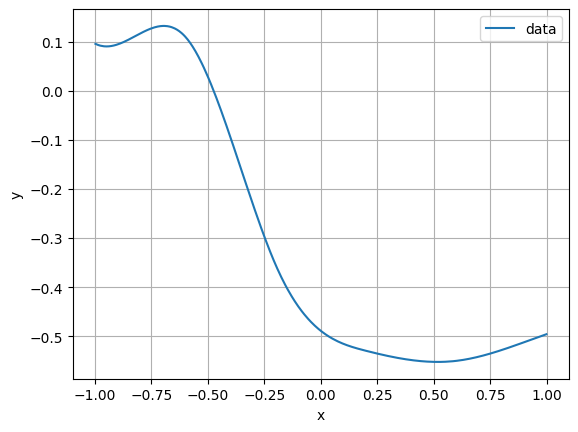

Generating Initial population population


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]


Best score:  -0.6757450307784159
Best ansatz:   params[0] + params[1] * x
Best params:  [-0.30618698 -0.42515418]
Generation: 1


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


Best score:  -0.015398798303648731
Best ansatz:   params[0] * np.sin(params[1] * x + params[2]) + params[3] * x + params[4]
Best params:  [-0.16346962 -3.91927372  2.05865976 -0.39318016 -0.33505285]
Exit condition met.
(0, 1, 0)


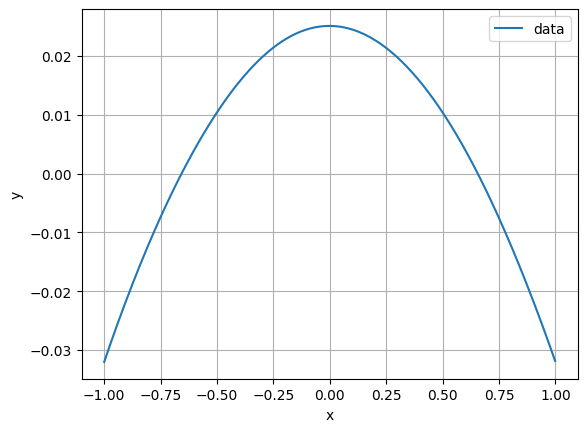

Generating Initial population population


100%|██████████| 10/10 [00:32<00:00,  3.25s/it]

Best score:  -1.3647733401932709e-05
Best ansatz:   params[0] + params[1] * x + params[2] * x**2
Best params:  [ 2.48723335e-02 -4.74985671e-05 -5.72396208e-02]
Exit condition met.
(1, 0, 0)


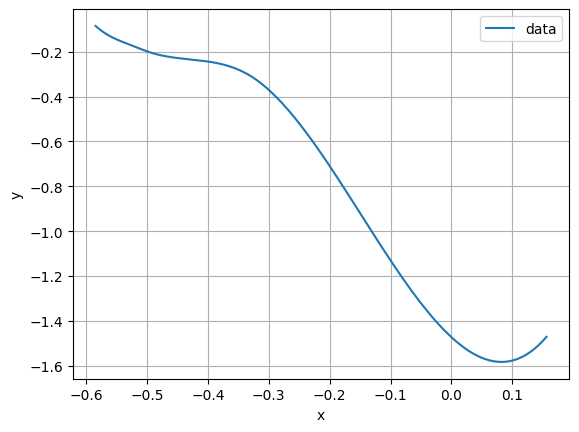

Generating Initial population population


100%|██████████| 10/10 [00:20<00:00,  2.08s/it]

Best score:  -0.026707896303736434
Best ansatz:   params[0] * x + params[1]
Best params:  [-2.20925851 -1.29872918]
Exit condition met.
(2, 0, 0)


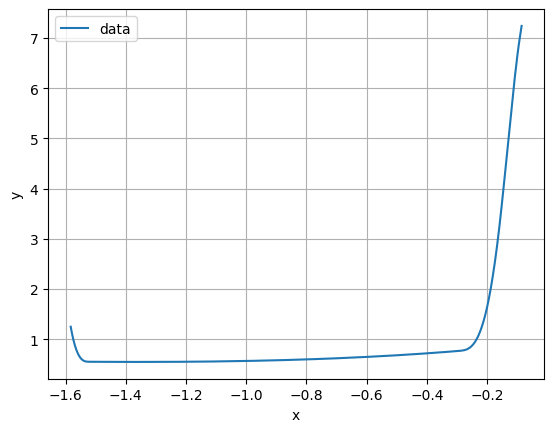

Generating Initial population population


100%|██████████| 10/10 [00:21<00:00,  2.19s/it]

Best score:  -0.050675124544618935
Best ansatz:   params[0] + params[1] * np.exp(params[2] * x)
Best params:  [ 0.69188912 37.73339716 17.37359689]
Exit condition met.


In [5]:
sym_expr = to_symbolic(model, client, gpt_model="openai/gpt-4o", exit_condition=min(res['train_loss']).item())

In [6]:
import pickle
with open('./sym_expr_4o.pkl', 'wb') as hnd:
    pickle.dump(sym_expr, hnd)

In [7]:
import pickle
with open('./sym_expr_4o.pkl', 'rb') as hnd:
    sym_expr = pickle.load(hnd)

In [8]:
initial_params = []
for kan_conn, sub_res in sym_expr[0].items():
    if sub_res is None:
        print(f"Could not fit a function for connection {kan_conn}")
        continue
    highest_score_element = max((item for sublist in sub_res for item in sublist), key=lambda item: item['score'])
    print(f"Approximation for {kan_conn}: {highest_score_element['ansatz'].strip()}")
    print(f"Parameters are {np.round(highest_score_element['params'], 1)}")
    initial_params += list(highest_score_element['params'])

Approximation for (0, 0, 0): params[0] * np.sin(params[1] * x + params[2]) + params[3] * x + params[4]
Parameters are [-0.2 -3.9  2.1 -0.4 -0.3]
Approximation for (0, 1, 0): params[0] + params[1] * x + params[2] * x**2
Parameters are [ 0.  -0.  -0.1]
Approximation for (1, 0, 0): params[0] * x + params[1]
Parameters are [-2.2 -1.3]
Approximation for (2, 0, 0): params[0] + params[1] * np.exp(params[2] * x)
Parameters are [ 0.7 37.7 17.4]


In [9]:
def learned_f(X, *params):
    x0, x1 = X
    l11, l12 = params[0] * np.sin(params[1] * x0 + params[2]) + params[3], params[4] * x1**2 + params[5] * x1 + params[6]
    l21 = params[7] * np.sin(params[8] * (l11+l12) + params[9]) + params[10]
    l31 = params[11] * np.exp(params[12] * l21) + params[13] * l21 + params[14]
    return l31

In [10]:
from scipy.optimize import curve_fit
initial_params = np.random.uniform(-1, 1, 15)
popt, _ = curve_fit(learned_f, (dataset['train_input'].cpu().detach().numpy()[:,0], dataset['train_input'].cpu().detach().numpy()[:,1]), dataset['train_label'].cpu().detach().numpy().flatten(), p0=initial_params, maxfev=100000)
popt

/var/folders/b6/m5qrk7z12lxb7lpygv99mnmw0000gn/T/ipykernel_4803/1459366936.py:5: RuntimeWarning: overflow encountered in exp
  l31 = params[11] * np.exp(params[12] * l21) + params[13] * l21 + params[14]


array([ 5.15724615,  9.92449308, 11.52972362,  2.63241047,  3.36803139,
        9.21379357,  2.86267318,  1.30928509, -0.73583313, -1.62641715,
        0.80189053,  1.62868168, -0.43993605,  0.66642854,  0.06103451])